In [1]:
import sys
import os
import cv2
import time
import numpy as np
import ffmpeg
import matplotlib.pyplot as plt
from pathlib import Path

repo_path = Path(".").absolute().parent
data_path = Path(".").absolute() / "videos"
    
sys.path.append(str(repo_path))

---

# Reference

https://github.com/mithi/advanced-lane-detection/blob/master/A-BASIC-LANE-DETECTION/BASIC_LANE_DETECTION.ipynb

# Basic Lane Detection with OpenCV

## 1. Load Data and Resize

In [4]:
from lanedetection import imreader, imsaver
img_path = "./imgs/test.jpg"
image = imreader(img_path)
height, width = 480, 640

def resize_image(img, width, height):
    return cv2.resize(img, (width, height))

def draw(img1, img2, tit1, tit2, cmap1=None, cmap2="gray"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    ax1.imshow(img1, cmap=cmap1)
    ax1.set_title(tit1)
    ax1.set_axis_off()

    ax2.imshow(img2, cmap=cmap2)
    ax2.set_title(tit2)
    ax2.set_axis_off()
    plt.tight_layout()
    plt.show()

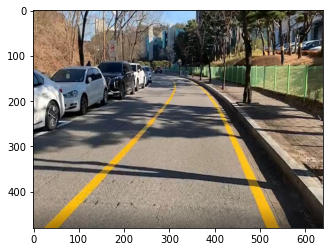

In [5]:
img = resize_image(image, width, height)
plt.imshow(img)
plt.show()

## 2. Gray Scaling & Gaussian Blur

- convert image to gray scale
- reduce noise using gaussian blur algorithm, with specified `kerner_size`

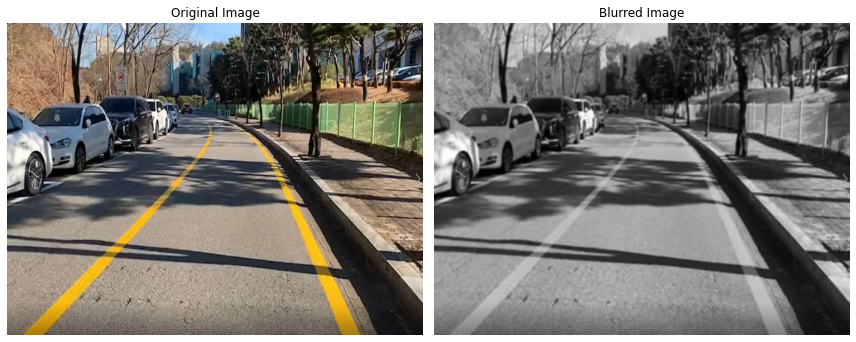

In [6]:
def gray_image(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(gray_img, kernel_size=5):
    return cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 0)

gray_img = gray_image(img)
blur_img = gaussian_blur(gray_img, kernel_size=5)
draw(img, blur_img, "Original Image", "Blurred Image")

## 3. canny transform algorithm

The Process of Canny edge detection algorithm can be broken down to 5 different steps:

1. Apply Gaussian filter to smooth the image in order to remove the noise
2. Find the intensity gradients of the image
3. Apply non-maximum suppression to get rid of spurious response to edge detection
4. Apply double threshold to determine potential edges
5. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

- [OpenCV References](https://docs.opencv.org/master/da/d22/tutorial_py_canny.html)
- [Korean Blog About Canny Filter](https://carstart.tistory.com/188)


In [7]:
def get_edges(blur_img, low_threshold=100, high_threshold=200):
    return cv2.Canny(blur_img, low_threshold, high_threshold)

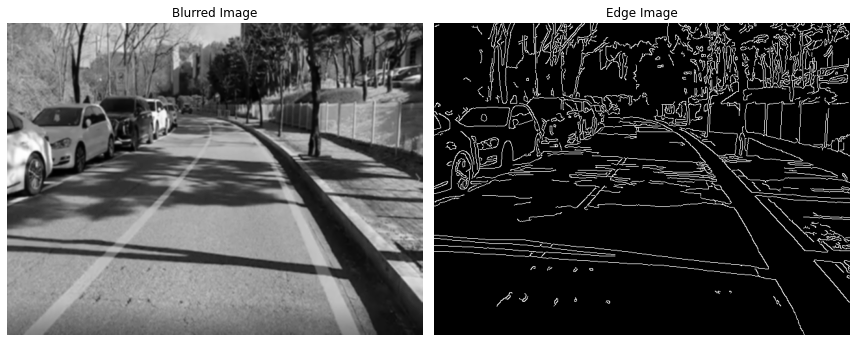

In [8]:
edge_img = get_edges(blur_img, low_threshold=100, high_threshold=100*2)
draw(blur_img, edge_img, "Blurred Image", "Edge Image", cmap1= "gray", cmap2="gray")

## 4. Get Region of Interest

In [9]:
def get_roi(edge_img, vertices, ignore_value = 255):
    '''get the polygon to be used to block out everything in the image except the region of interest'''
    roi = np.zeros_like(edge_img)
    cv2.fillPoly(roi, vertices, ignore_value)
    return roi

def mask(edge_img, roi):
    '''block out everything in the image except the edges in the region of interest'''
    return cv2.bitwise_and(edge_img, roi)

def get_vertices(w, h, axc, bxc, cyc, dyc, maxyc = 1.0, maxxc = 1.0, startxc = 0.0):
    ax = int(axc*w)
    bx = int(bxc*w)
    cy = int(cyc*h)
    dy = int(dyc*h)
    maxy = int(maxyc*h)
    maxx = int(maxxc*w)
    startx = int(startxc*w)
    bottom_left = (startx, maxy)
    top_left = (ax, cy)
    top_right = (bx, dy)
    bottom_right = (maxx, maxy)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices 

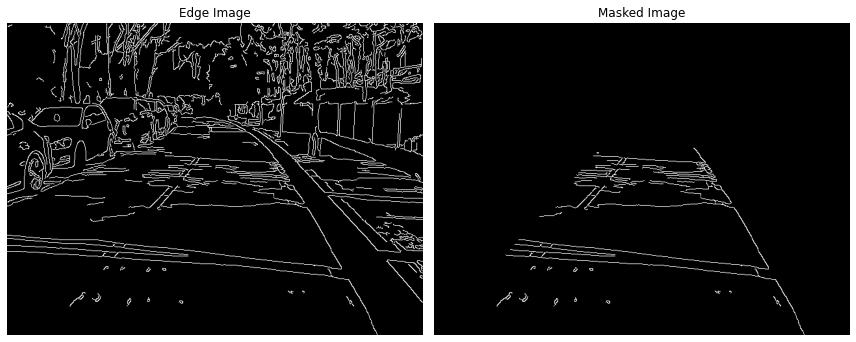

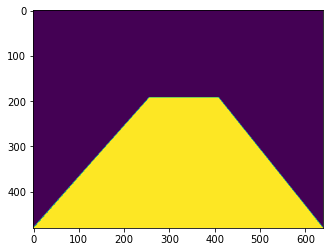

In [10]:
ax_coef = 10.0/25
bx_coef = 16.0/25
cy_coef = 0.4
dy_coef = 0.4
maxy_coef = 1.0
maxx_coef = 1.0
startx_coef = 0.0

height, width = edge_img.shape
vertices = get_vertices(width, height, ax_coef, bx_coef, cy_coef, dy_coef, maxy_coef, maxx_coef, startx_coef)

roi = get_roi(edge_img, vertices)
mask_img = mask(edge_img, roi)
draw(edge_img, mask_img, "Edge Image", "Masked Image", cmap1= "gray", cmap2="gray")
plt.imshow(roi)
plt.show()

## 5. Get the line

- `Rho`, `theta_coeff` - distance (pixels) and angular (degrees, converted to radians inside) resolutions of our grid in hough space, starting from one, we can scale this value up to be more flexible in what constitutes a line
- `Min_vote` - the number of intersections in a given grid cell a candidate line needs to have to make it into the output
- `Min_line_length` - the minimum length of the line in pixels that we can accept as an output
- `Max_line_gap` - the maximum distance in pixels between segments that we allow to be connected in a single line


In [11]:
def get_lines(masked_edge_image, rho, theta_coef, min_votes, min_line_length, max_line_gap):
    '''convert edges into lines using hough transform algorithm '''
    theta = theta_coef * np.pi/180
    return cv2.HoughLinesP(masked_edge_image, rho, theta, min_votes, np.array([]), 
                           minLineLength=min_line_length, maxLineGap=max_line_gap)

def draw_lines(lines, image, color=[255, 0, 0], thickness=2, thresh=0.5):
    ''' draw the lines on a blank image'''
    lined_image = np.copy(image)*0

    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope, intercept = np.polyfit((x1,x2), (y1,y2), 1)
                if abs(slope) > thresh:
                    cv2.line(lined_image, (x1, y1), (x2, y2), color, thickness)

    return lined_image

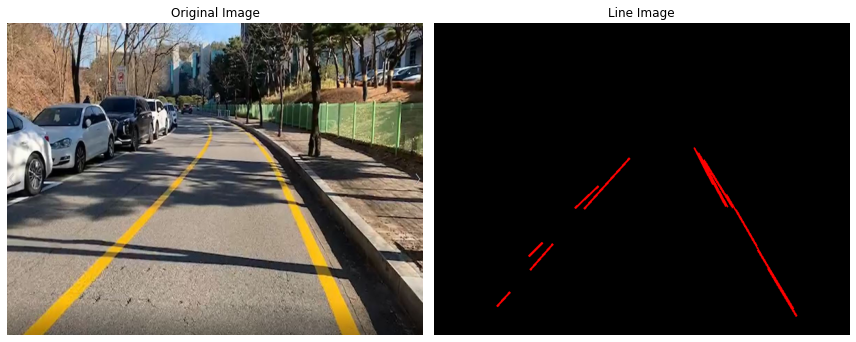

In [12]:
rho = 1
theta_coef = 1 
min_votes = 30
min_line_length = 20 
max_line_gap = 20

lines = get_lines(mask_img, rho, theta_coef, min_votes, min_line_length, max_line_gap)
line_img = draw_lines(lines, img)
draw(img, line_img, "Original Image", "Line Image", cmap1=None, cmap2=None)

## 5. Extrapolate

In [13]:
def extrapolate_lines(lines, image, color=[255, 0, 0], thickness = 10, 
                      positive_thresh = 0.5, negative_thresh = 0.5):
    
    imshape = image.shape
    image = np.copy(image)*0

    #initialize minimum and maximum y coordinate 
    minimum_y = image.shape[0] 
    maximum_y = image.shape[0]

    #initialize groups of values into empty lists
    left_slopes = []
    left_xs = []
    left_ys = []   
    right_slopes = []
    right_xs = []
    right_ys = []
  
    # segregate the small line segments into the left lane group or right lane group
    if lines is not None:  
        for line in lines:
            for x1,y1,x2,y2 in line:
        
                # get the slope and intercept of the line (as defined by two points) using the polyfit function
                slope, intercept = np.polyfit((x1,x2), (y1,y2), 1)
            
                if (slope > positive_thresh): #if positive slope, put value to left lane group
                    left_slopes += [slope]
                    left_xs += [x1, x2]
                    left_ys += [y1, y2]
                elif (slope < negative_thresh): #if negative slope, put value to right lane group
                    right_slopes += [slope]
                    right_xs += [x1, x2]
                    right_ys += [y1, y2]

                # update the minimum y_coordinate based on values seen
                minimum_y = min(min(y1, y2), minimum_y)
  
    #average all the values in each group to get the slope, x, and y
    left_slope = np.mean(left_slopes)
    left_x = np.mean(left_xs)
    left_y = np.mean(left_ys)
    right_slope = np.mean(right_slopes)
    right_x = np.mean(right_xs)
    right_y = np.mean(right_ys)
    
    #derive the intercept using the equation of the line and average value
    left_intercept = left_y - (left_slope * left_x)
    right_intercept = right_y - (right_slope * right_x)

    if ((len(left_slopes) > 0) and (len(right_slopes) > 0)): #make sure we have points in each group
        #derive the x coordinate using the equation of the lines and derived values
        upper_left_x = int((minimum_y - left_intercept) / left_slope)
        lower_left_x = int((maximum_y - left_intercept) / left_slope)
        upper_right_x = int((minimum_y - right_intercept) / right_slope)
        lower_right_x = int((maximum_y - right_intercept) / right_slope)
    
        #draw the line based on two points 
        cv2.line(image, (upper_left_x, minimum_y), (lower_left_x, maximum_y), color, thickness)
        cv2.line(image, (upper_right_x, minimum_y), (lower_right_x, maximum_y), color, thickness)
    
    return image

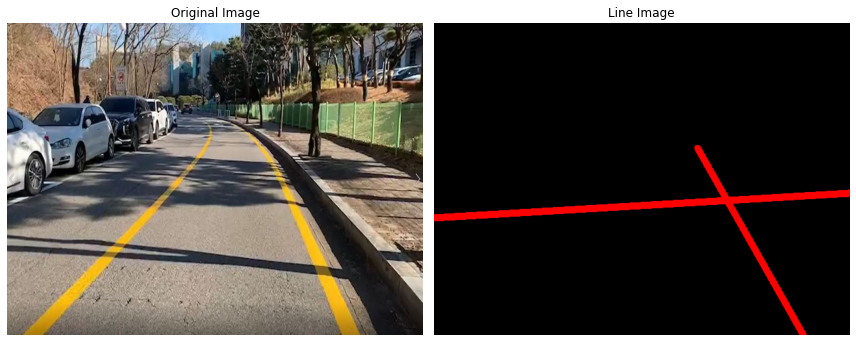

In [14]:
line_img2 = extrapolate_lines(lines, img, thickness=10, positive_thresh=0.5, negative_thresh=0.5)
draw(img, line_img2, "Original Image", "Line Image", cmap1=None, cmap2=None)

## 6. overlap

In [15]:
def overlap(first_image, second_image, alpha=0.8, beta=0.5, lamb=0.0):
    '''first_image * α + second_image * β + λ (colored)'''
    return cv2.addWeighted(first_image, alpha, second_image, beta, lamb)

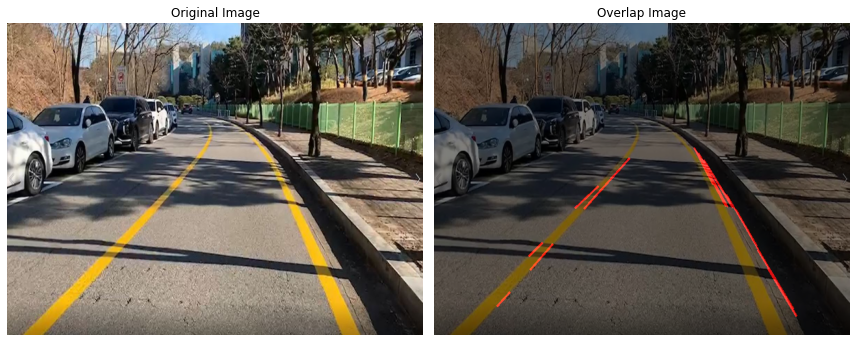

In [16]:
final_img = overlap(line_img, img)
draw(img, final_img, "Original Image", "Overlap Image", cmap1=None, cmap2=None)

---

In [17]:
def check_rotation(path_video_file):
    # this returns meta-data of the video file in form of a dictionary
    meta_dict = ffmpeg.probe(path_video_file)

    # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
    # we are looking for
    rotate_code = None
    if int(meta_dict['streams'][0]['tags']['rotate']) == 90:
        rotate_code = cv2.ROTATE_90_CLOCKWISE
    elif int(meta_dict['streams'][0]['tags']['rotate']) == 180:
        rotate_code = cv2.ROTATE_180
    elif int(meta_dict['streams'][0]['tags']['rotate']) == 270:
        rotate_code = cv2.ROTATE_90_COUNTERCLOCKWISE

    return rotate_code

def correct_rotation(frame, rotate_code):
     return cv2.rotate(frame, rotate_code)
    
def correct_rgb(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def pipeline(img, params):
    gray_img = gray_image(img)  # Gray scale
    blur_img = gaussian_blur(gray_img, kernel_size=params["kernel_size"])  # Blur
    edge_img = get_edges(blur_img, 
                         low_threshold=params["canny_lo"], 
                         high_threshold=params["canny_hi"])
    height, width = edge_img.shape
    vertices = get_vertices(width, height, 
                            params["ax_coef"], 
                            params["bx_coef"], 
                            params["cy_coef"], 
                            params["dy_coef"], 
                            params["maxy_coef"], 
                            params["maxx_coef"], 
                            params["startx_coef"])
    roi = get_roi(edge_img, vertices)
    mask_img = mask(edge_img, roi)
    lines = get_lines(mask_img, 
                      params["rho"], 
                      params["theta_coef"], 
                      params["min_votes"], 
                      params["min_line_length"], 
                      params["max_line_gap"])
    
    line_img = draw_lines(lines, img)
    final_img = overlap(line_img, img)
    
#     line_img2 = extrapolate_lines(lines, img)
#     final_img = overlap(line_img2, img)

    return final_img

In [18]:
params = {
   #blur parameters
  "kernel_size": 3, 
    
   #canny transform parameters
  "canny_lo": 100, 
  "canny_hi": 100*3, 

  #region of interest parameters
  "ax_coef": 10.0/25,
  "bx_coef": 16.0/25,
  "cy_coef": 0.4,
  "dy_coef": 0.4,
  "maxy_coef": 1.0,
  "maxx_coef": 1.0,
  "startx_coef": 0.0,

  #hough parameters
  "rho": 1, 
  "theta_coef": 1, 
  "min_votes": 30, 
  "min_line_length": 20, 
  "max_line_gap": 20
}


In [19]:
video_path = str(data_path / "sample_video1.mp4")
cap = cv2.VideoCapture(video_path)
rotate_code = check_rotation(video_path)
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        frame = correct_rotation(frame, rotate_code)
        frame = resize_image(frame, width, height)
        # pipe line
        processed = pipeline(frame, params)
        # processed = np.repeat(processed[:, :, np.newaxis], 3, axis=2)
        images = np.hstack([frame, processed])
        cv2.imshow("video", images)
        key = cv2.waitKey(1)
        if key == 27:
            cv2.destroyAllWindows()
            break
    else:
        break
    #cv2.imshow('frame', ti[0])
if not ret:
    cv2.destroyAllWindows()